In [1]:
# Module imports

import numpy as np
import matplotlib.pyplot as plt
from LRFutils import archive, progress
from src import plot
from scipy import ndimage

In [2]:
# Function definition 

def gaussian(x, mu, sigma):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def plummer(r, a):
    return 3/(4*np.pi*a**3)*(1 + r**2 / a**2)**(-5/2)

In [3]:
# Config

N = 64 # resolution in pixel
space_range = [-1, 1] # space interval (arbitrary unit)

In [4]:
# Initializations

r, dr = np.linspace(space_range[0], space_range[1], N, endpoint=True, retstep=True)
X, Y, Z = np.meshgrid(r, r, r)

---

# Dennsity generation

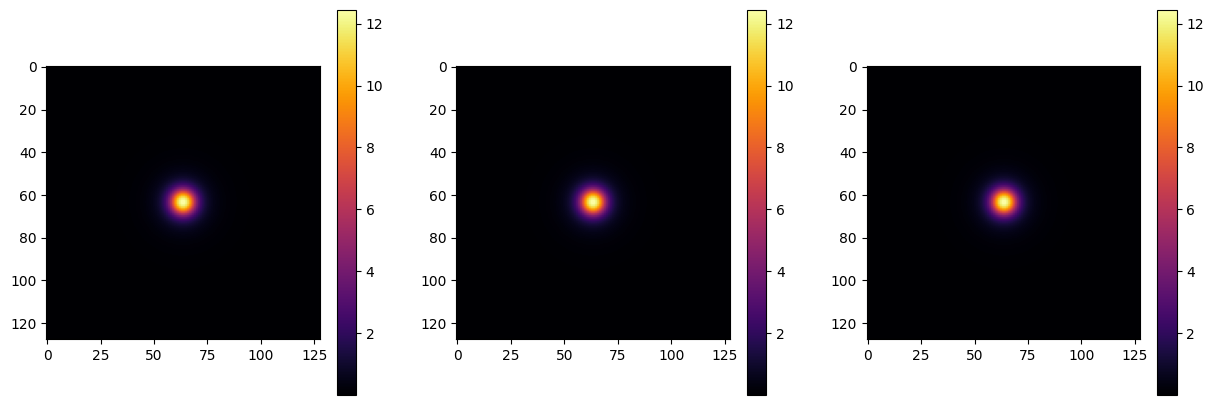

In [5]:
# Generating lorentzian in a bigger space

tmp_r, tmp_dr = np.linspace(space_range[0]*2, space_range[1]*2, N*2, endpoint=True, retstep=True)
tmp_X, tmp_Y, tmp_Z = np.meshgrid(tmp_r, tmp_r, tmp_r)

cloud = 1/(1+(tmp_X**2+tmp_Y**2+tmp_Z**2)**2*1000)

plot.sum_in_3_directions(cloud)

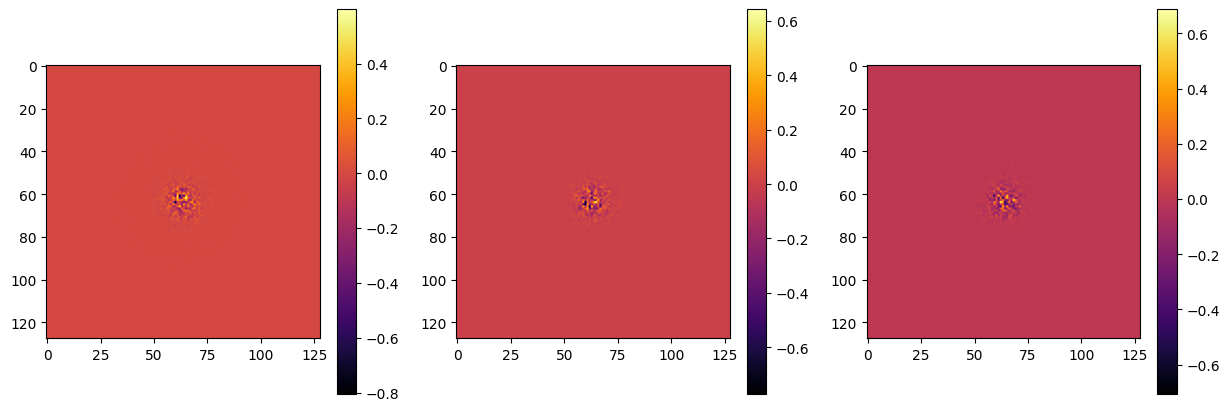

In [6]:
# Adding noise

cloud *= np.random.normal(0, 0.1, size=(N*2, N*2, N*2))
plot.sum_in_3_directions(cloud)

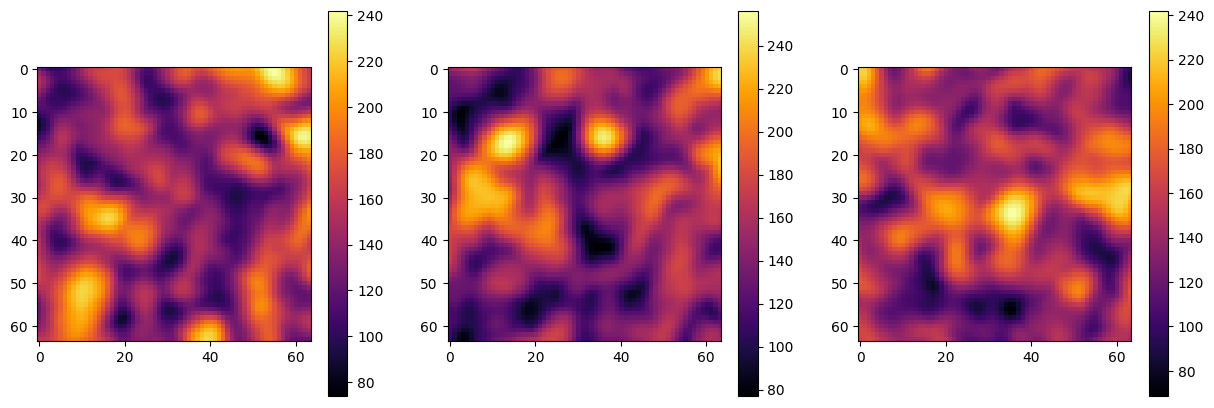

In [7]:
# Computing the fourier transform and cropping to a smaller space
# in order to avoid symmetries induced by the lorentzian shape

cloud = np.abs(np.fft.fftn(cloud))
cloud = cloud[:N, :N, :N]

plot.sum_in_3_directions(cloud)

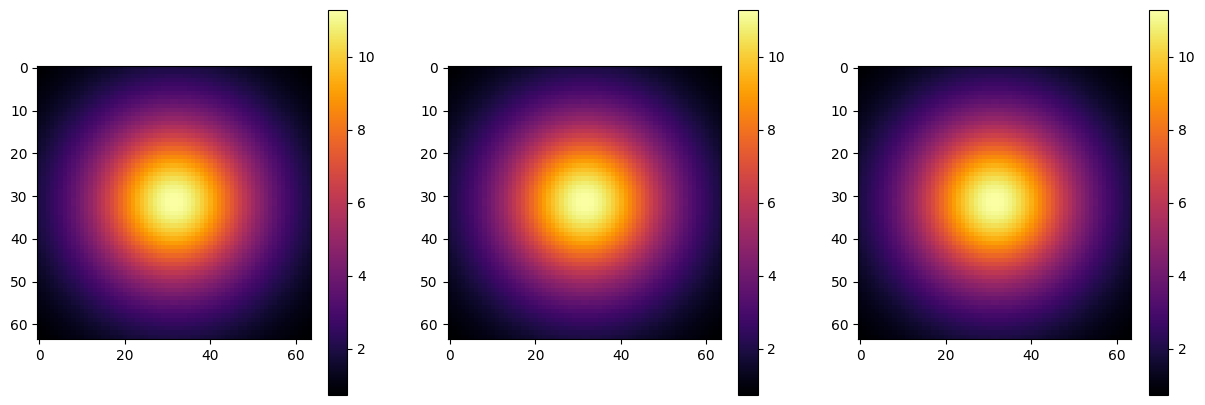

In [8]:
a = 0.9
p = plummer(np.sqrt(X**2+Y**2+Z**2), a)
plot.sum_in_3_directions(p)

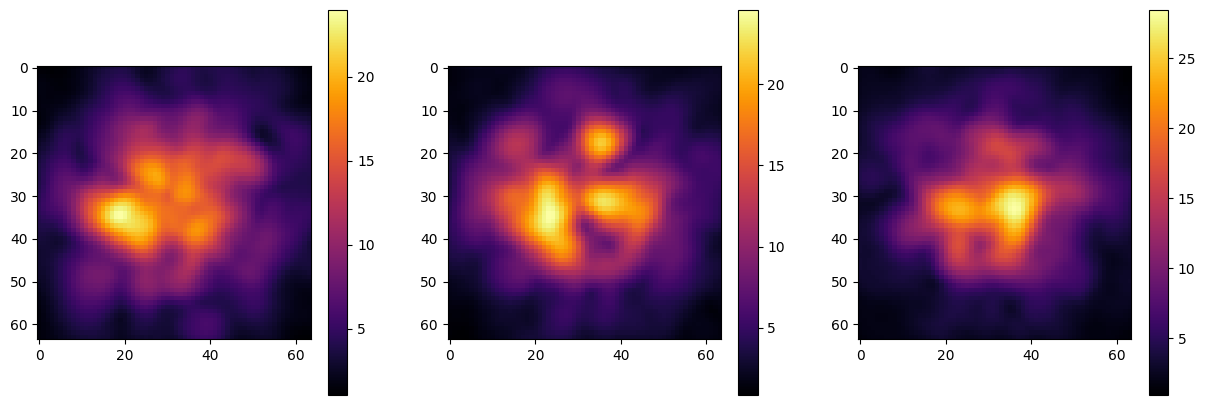

In [9]:
cloud *= p
cloud = cloud / np.amax(cloud) # normalizing
plot.sum_in_3_directions(cloud)

---

# Velocity generation

In [10]:
cloud_gradient = np.gradient(cloud, dr)

vx_grad = cloud_gradient[0] / np.amax(np.abs(cloud_gradient[0]))
vy_grad = cloud_gradient[1] / np.amax(np.abs(cloud_gradient[1]))
vz_grad = cloud_gradient[2] / np.amax(np.abs(cloud_gradient[2]))

# Removing aberrant values at the edges
for v in [vx_grad, vy_grad, vz_grad]:
    v[0,:,:] = 0
    v[-1,:,:] = 0
    v[:,0,:] = 0
    v[:,-1,:] = 0
    v[:,:,0] = 0
    v[:,:,-1] = 0

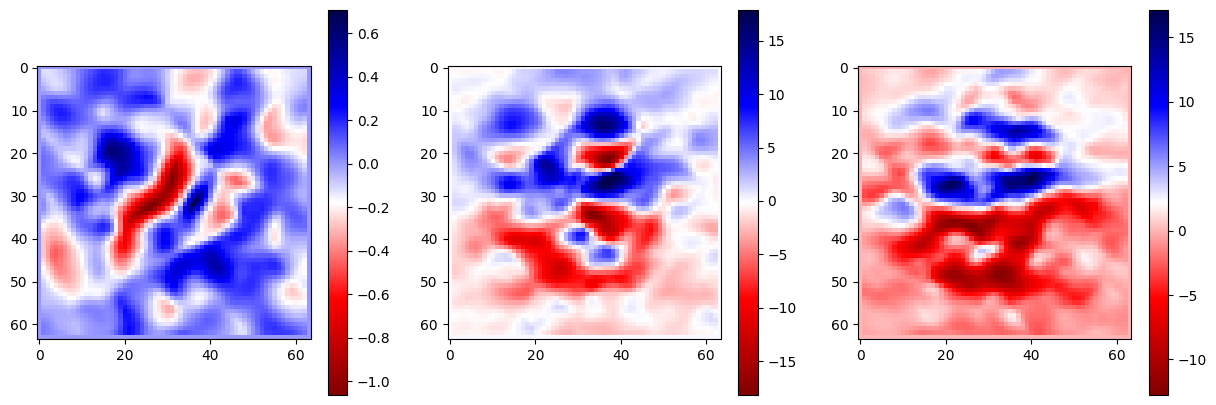

In [11]:
plot.sum_in_3_directions(vx_grad, "seismic_r")

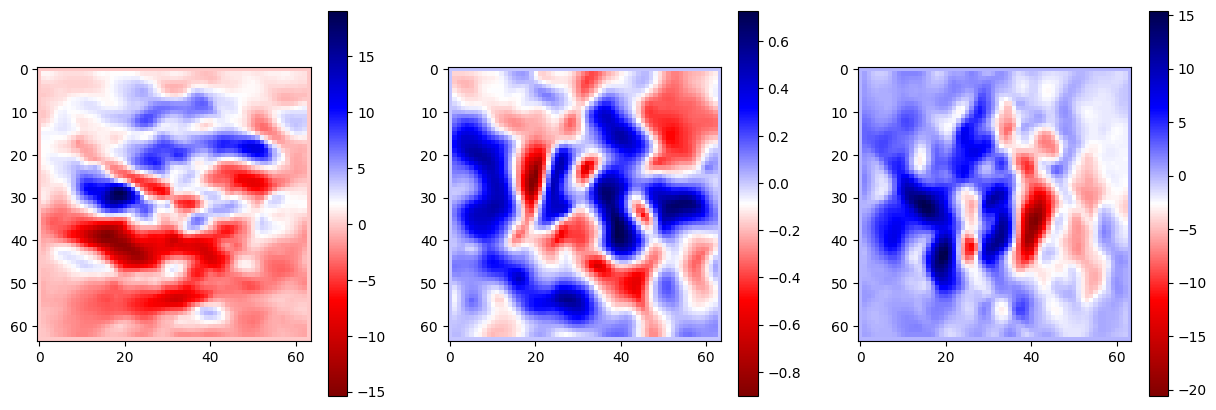

In [12]:
plot.sum_in_3_directions(vy_grad, "seismic_r")

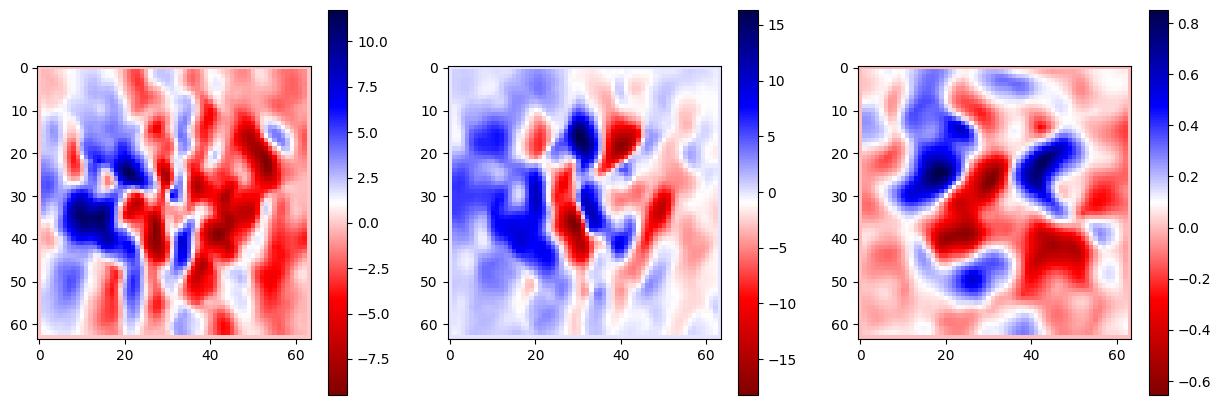

In [13]:
plot.sum_in_3_directions(vz_grad, "seismic_r")

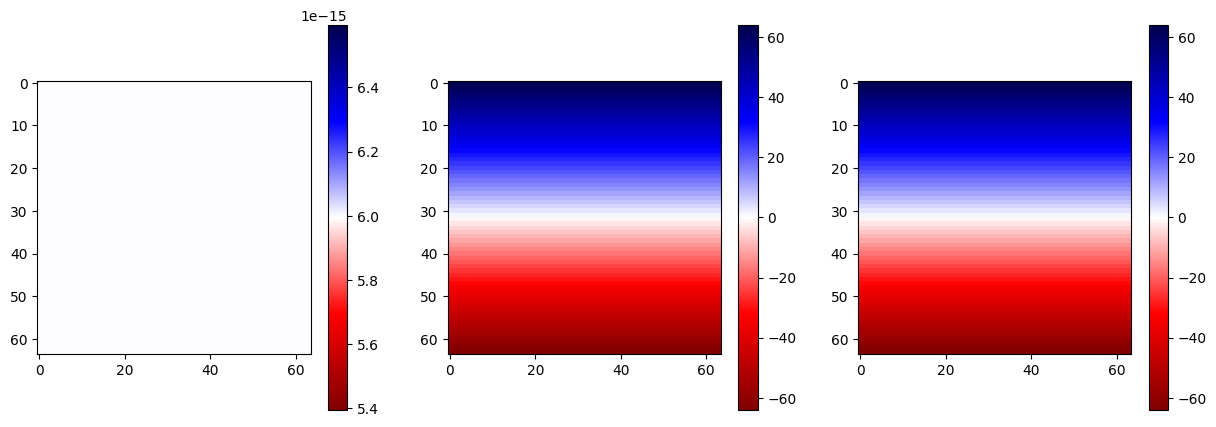

In [14]:
vx_rot = -Y / np.amax(np.abs(Y))
vy_rot = X  / np.amax(np.abs(X))
vz_rot = X * 0

plot.sum_in_3_directions(vx_rot, "seismic_r")

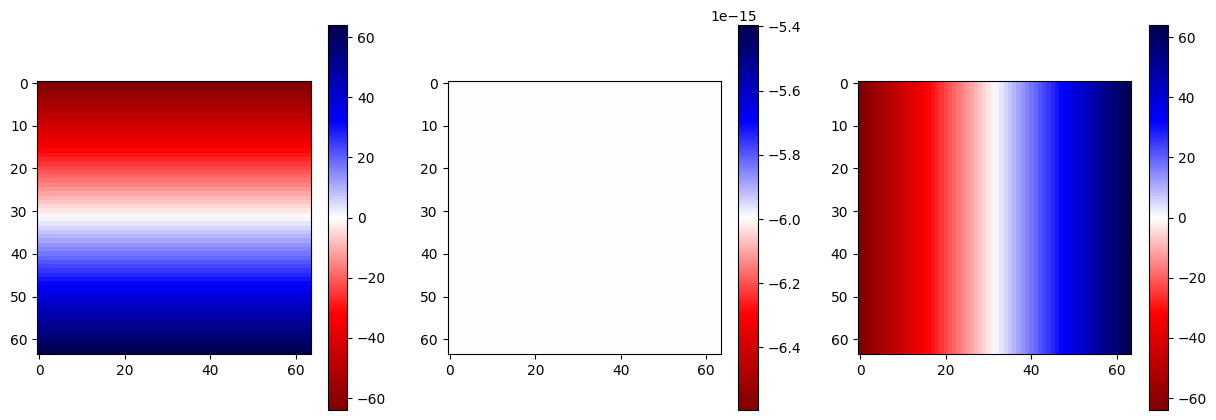

In [15]:

plot.sum_in_3_directions(vy_rot, "seismic_r")

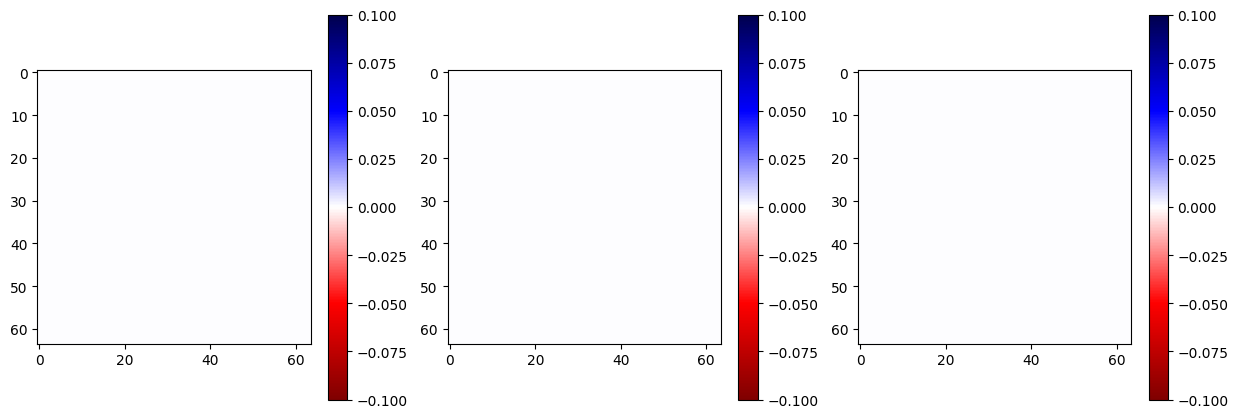

In [16]:

plot.sum_in_3_directions(vz_rot, "seismic_r")

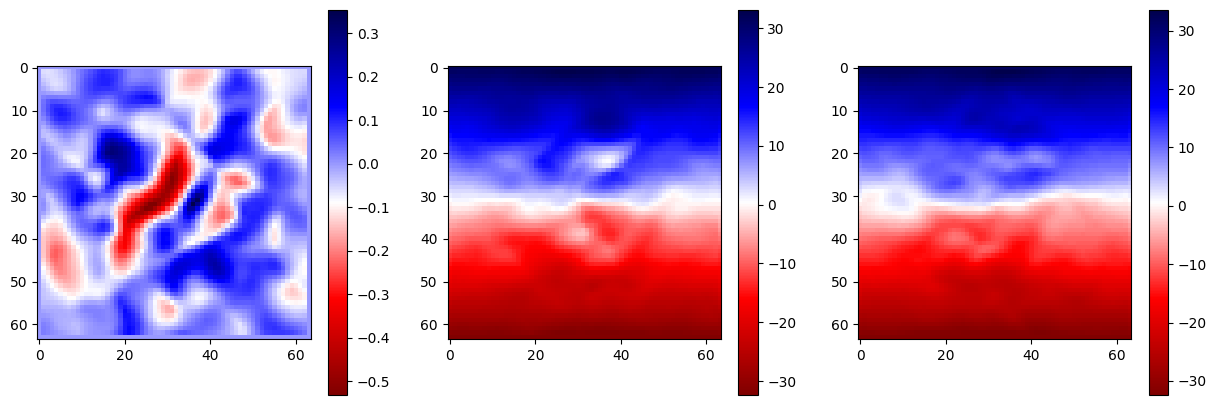

In [17]:
vx = (vx_grad + vx_rot)/2
vy = (vy_grad + vy_rot)/2
vz = (vz_grad + vz_rot)/2

plot.sum_in_3_directions(vx, "seismic_r")

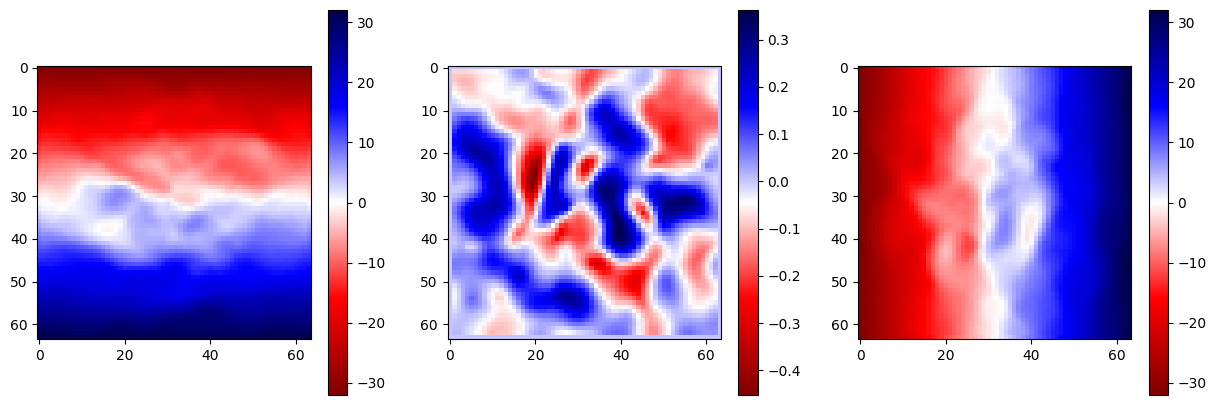

In [18]:
plot.sum_in_3_directions(vy, "seismic_r")

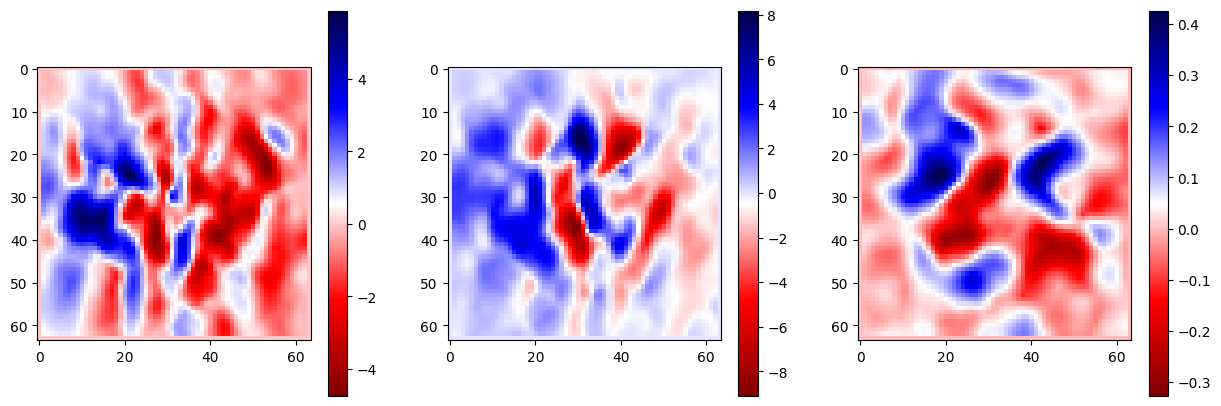

In [19]:
plot.sum_in_3_directions(vz, "seismic_r")    

---

# Spectrum generation

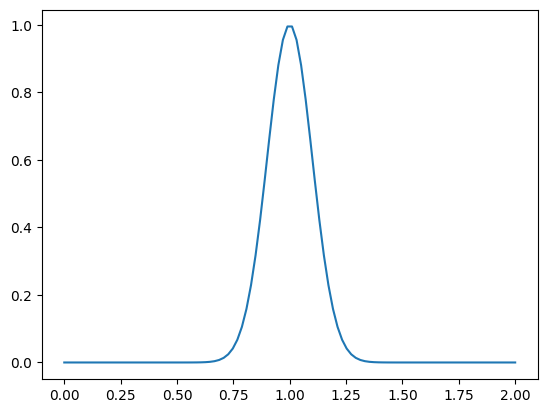

In [20]:
f = np.linspace(0, 2, 100) # frequency range

# def lorentzian(x, mu, gamma):
#     return gamma / np.pi / ((x - mu)**2 + gamma**2)

# def voigt(x, mu, sigma, gamma):
#     return np.real(np.fft.ifft(np.fft.fft(gaussian(x, mu, sigma)) * np.fft.fft(lorentzian(x, mu, gamma))))

gauss_profile = gaussian(f, 1, 0.1)
plt.plot(f, gauss_profile)
plt.show()

In [21]:
spectrum_hypercube_x = np.zeros((N, N, N, 100))
spectrum_hypercube_y = np.zeros((N, N, N, 100))
spectrum_hypercube_z = np.zeros((N, N, N, 100))

for i in range(N):
    for j in range(N):
        for k in range(N):
            spectrum_hypercube_x[i,j,k,:] = gaussian(f+3*vx[i,j,k], 1, 0.3) * cloud[i,j,k]
            spectrum_hypercube_y[i,j,k,:] = gaussian(f+3*vy[i,j,k], 1, 0.3) * cloud[i,j,k]
            spectrum_hypercube_z[i,j,k,:] = gaussian(f+3*vz[i,j,k], 1, 0.3) * cloud[i,j,k]

# Stacking to 2D observation
spectrum_hypercube_x = np.sum(spectrum_hypercube_x, axis=0)
spectrum_hypercube_y = np.sum(spectrum_hypercube_y, axis=1)
spectrum_hypercube_z = np.sum(spectrum_hypercube_z, axis=2)

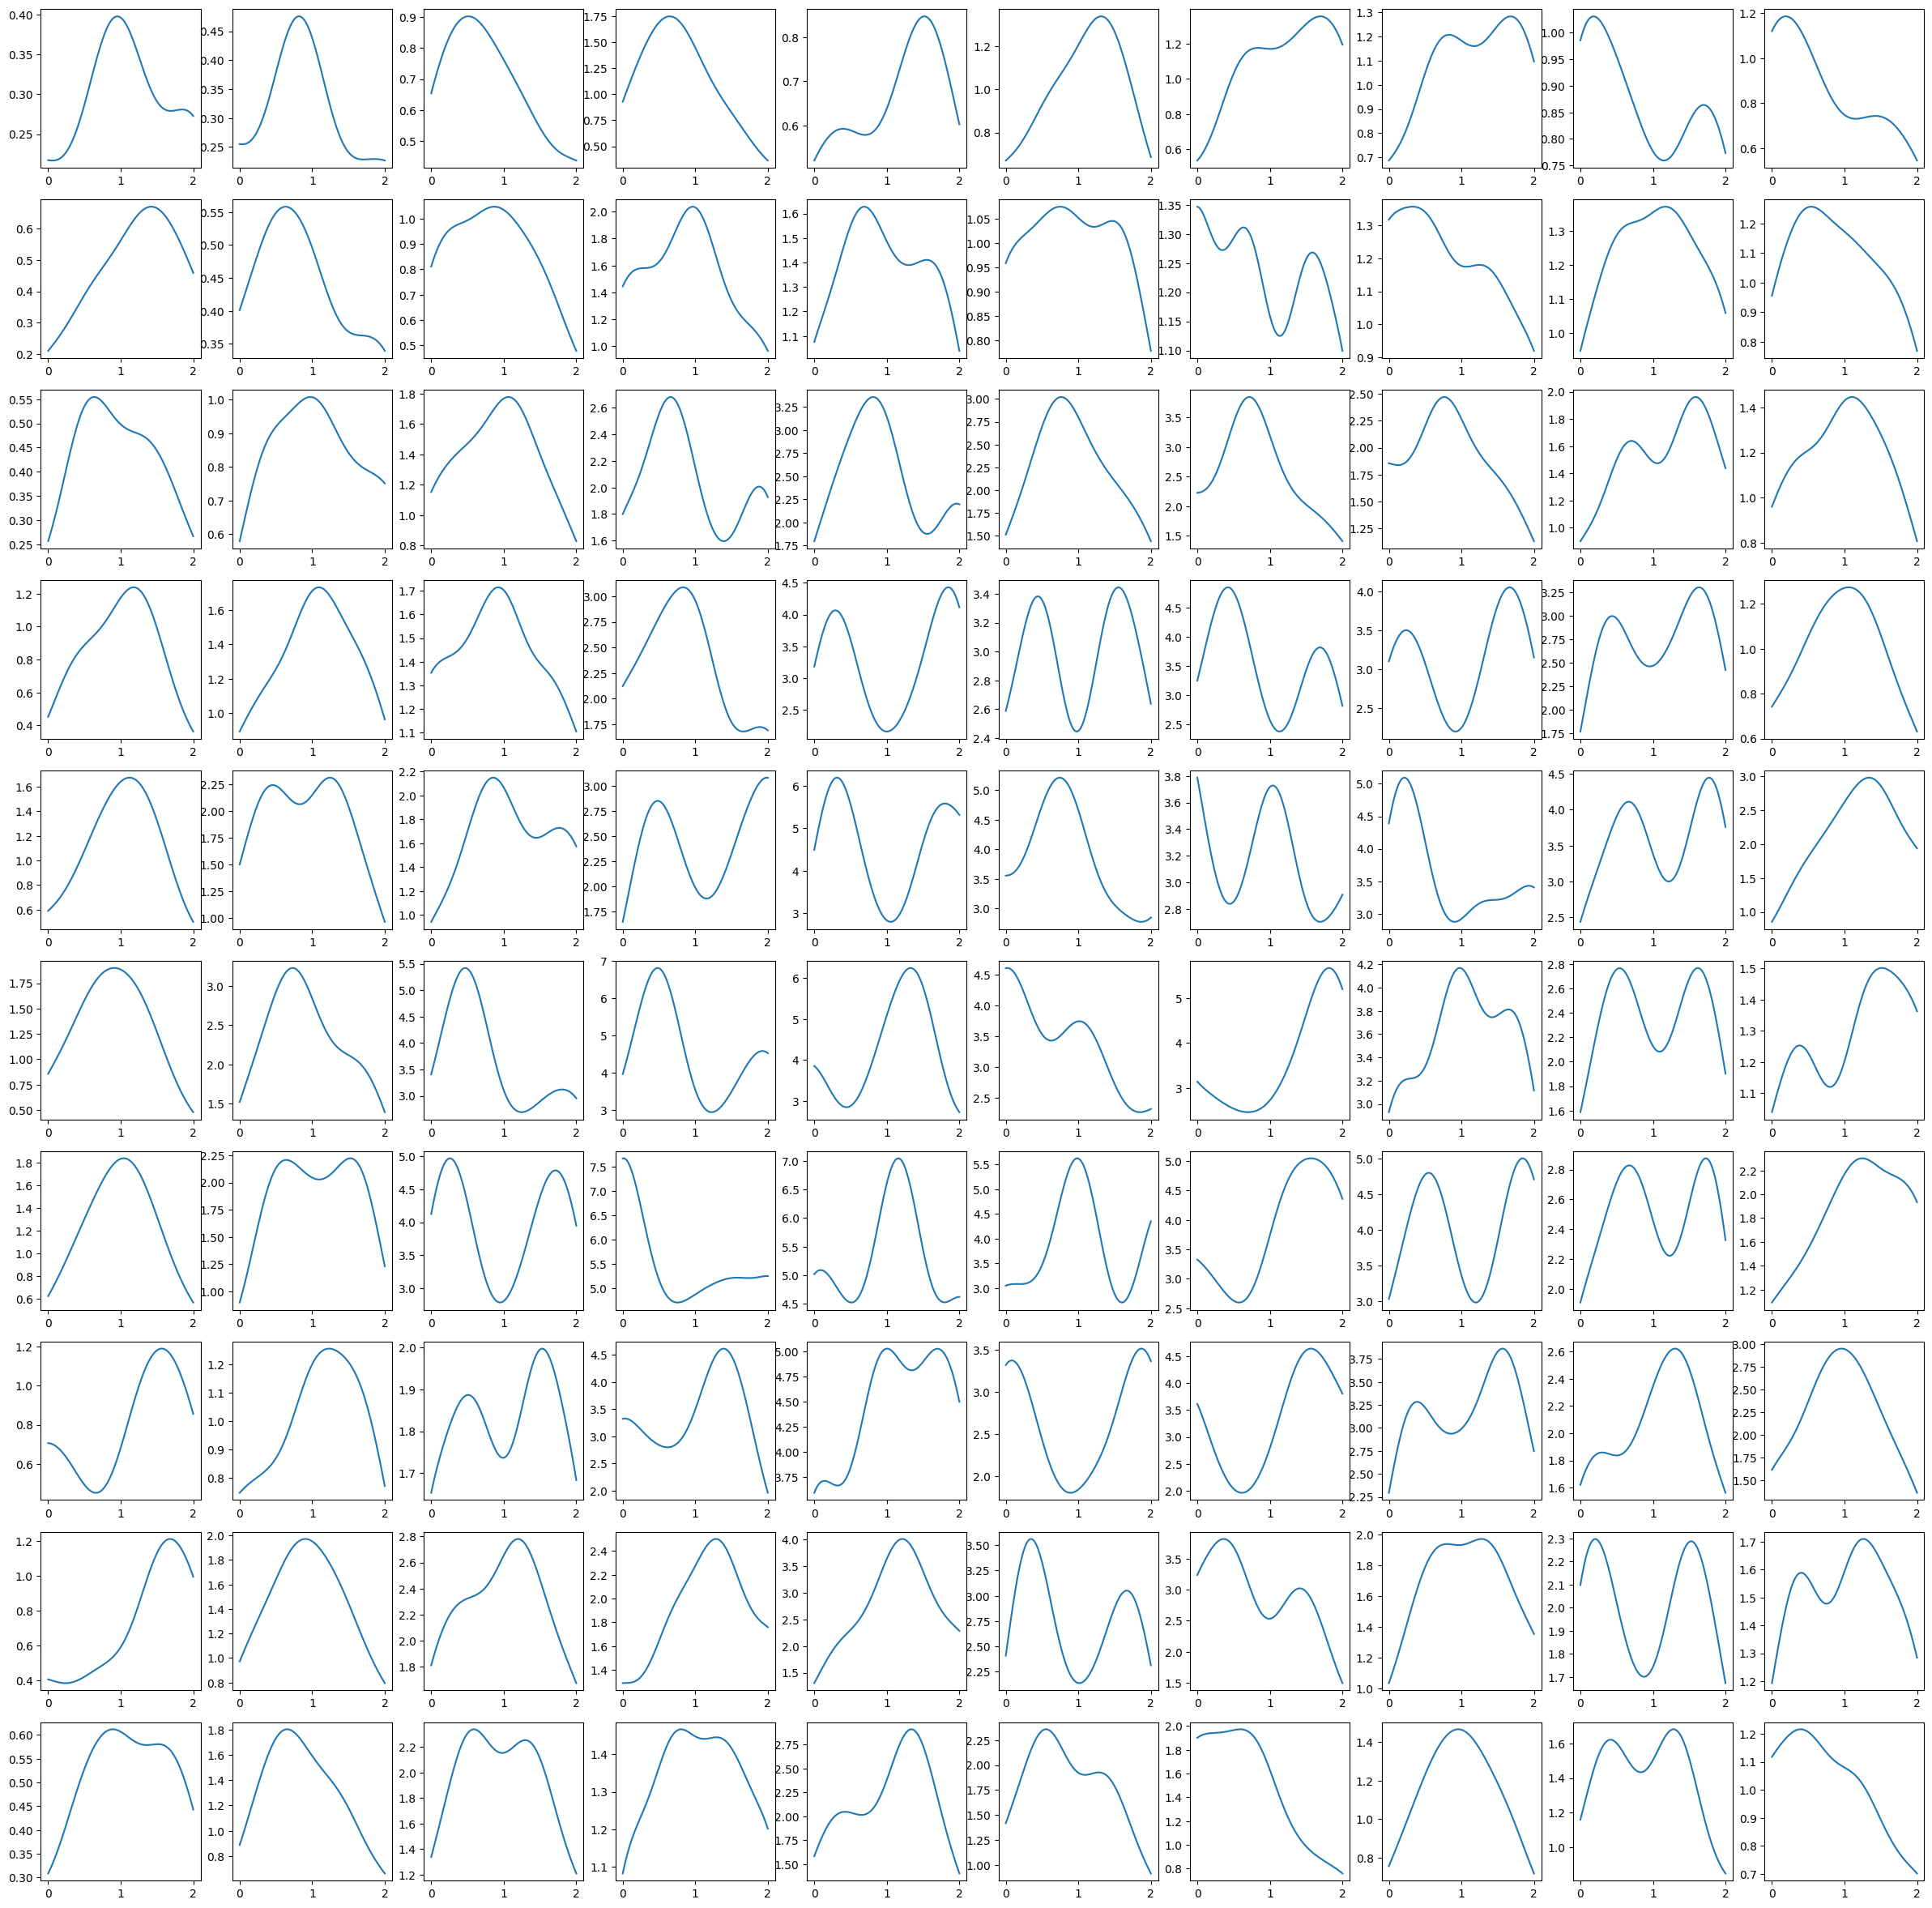

In [22]:
fig, axs = plt.subplots(10, 10, figsize=(30, 30))

# # Taking the mean of windows of N//10 pixels
# repr_x = np.zeros((10, 10, 100))
# for i in range(10):
#     for j in range(10):
#         repr_x[i,j,:] = np.mean(spectrum_hypercube_x[i*N//10:(i+1)*N//10, j*N//10:(j+1)*N//10, :], axis=(0,1))

# Taking one pixel every 10
repr_x = spectrum_hypercube_x[::N//10,::N//10, :]

for i in range(10):
    for j in range(10):
        axs[i,j].plot(f, repr_x[i,j,:])

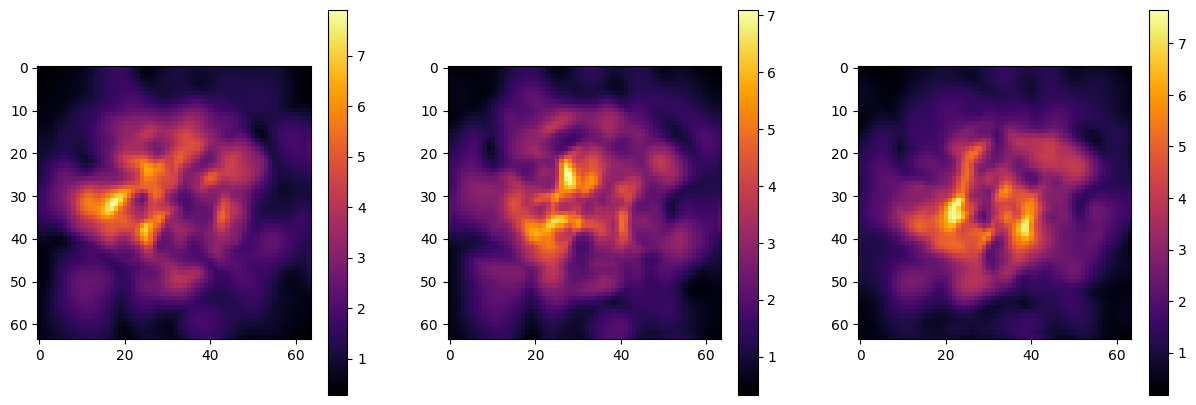

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im = axs[0].imshow(spectrum_hypercube_x[:,:,25], cmap="inferno")
fig.colorbar(im)
im = axs[1].imshow(spectrum_hypercube_x[:,:,50], cmap="inferno")
fig.colorbar(im)
im = axs[2].imshow(spectrum_hypercube_x[:,:,75], cmap="inferno")
fig.colorbar(im)
plt.show()

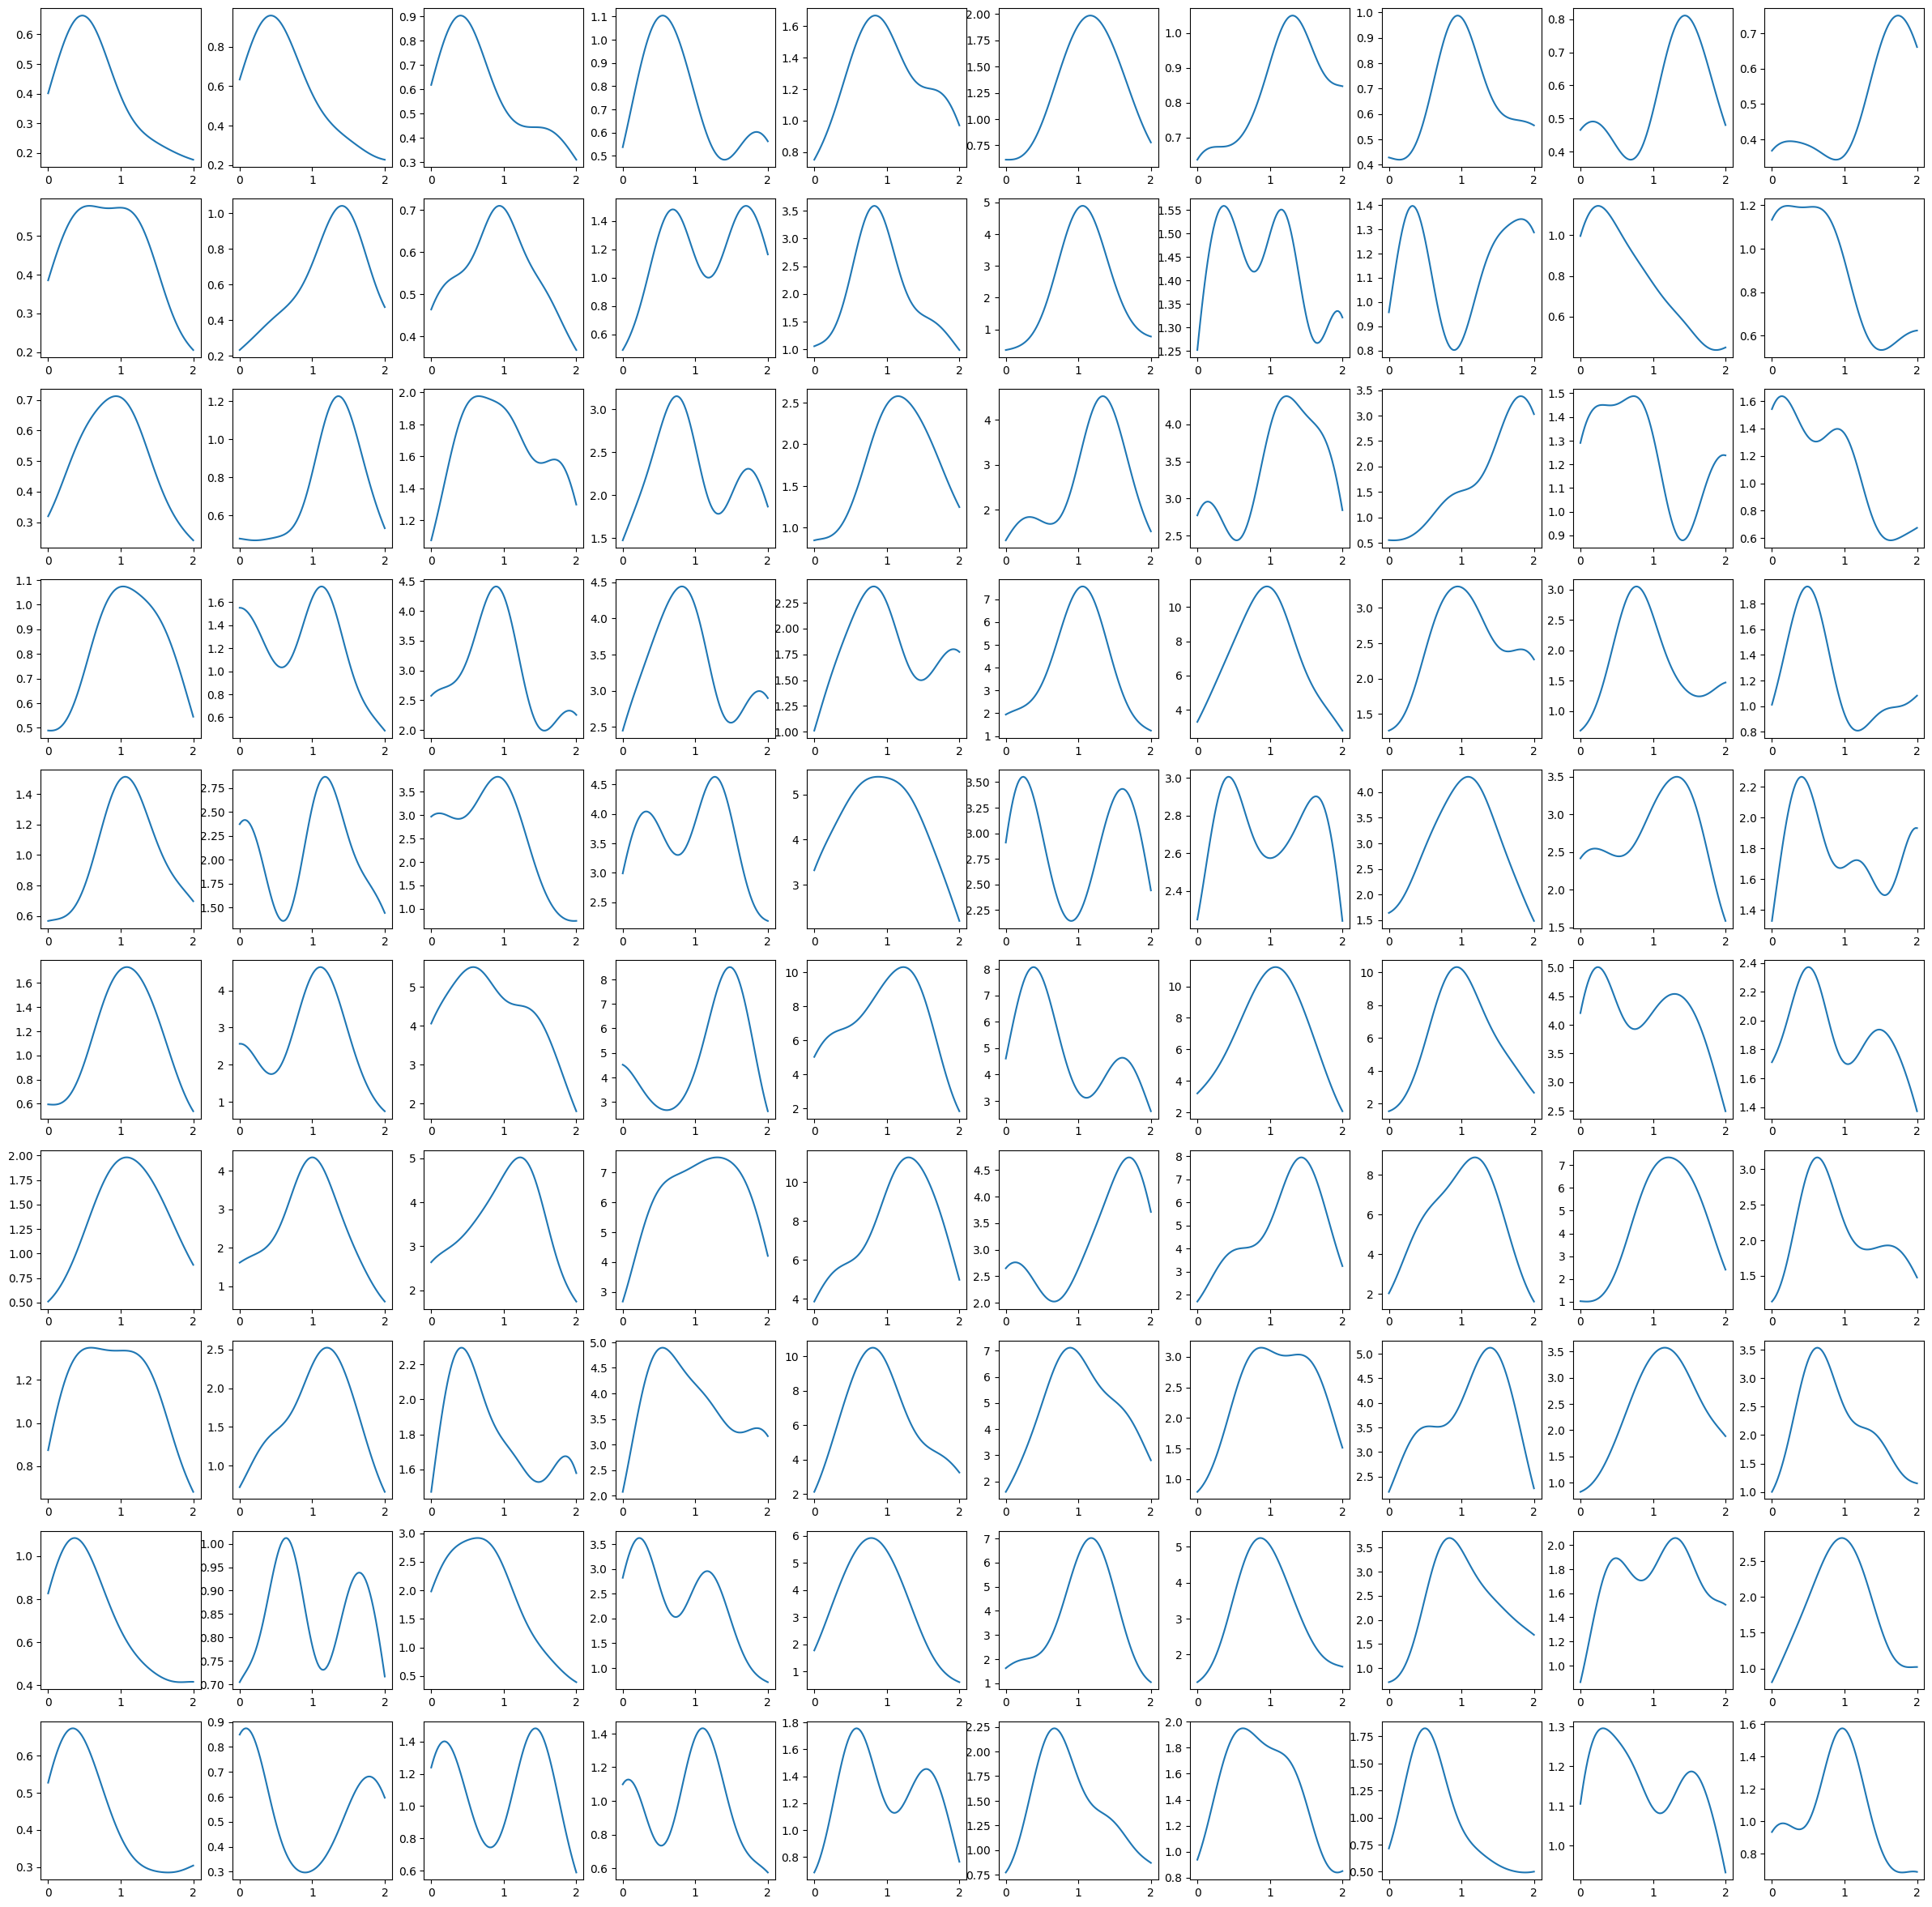

In [24]:
fig, axs = plt.subplots(10, 10, figsize=(30, 30))

# # Taking the mean of windows of N//10 pixels
# repr_y = np.zeros((10, 10, 100))
# for i in range(10):
#     for j in range(10):
#         repr_y[i,j,:] = np.mean(spectrum_hypercube_y[i*N//10:(i+1)*N//10, j*N//10:(j+1)*N//10, :], axis=(0,1))

# Taking one pixel every 10
repr_y = spectrum_hypercube_y[::N//10,::N//10, :]

for i in range(10):
    for j in range(10):
        axs[i,j].plot(f, repr_y[i,j,:])

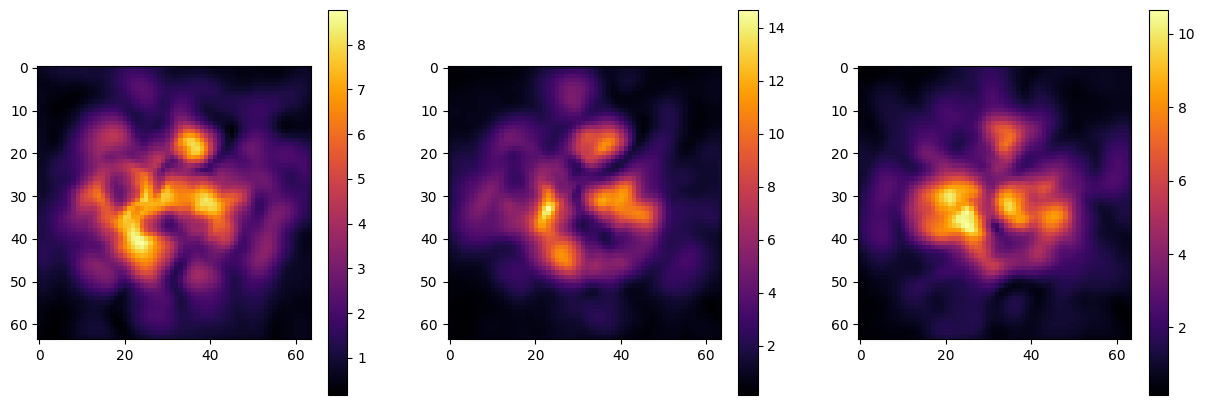

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im = axs[0].imshow(spectrum_hypercube_y[:,:,25], cmap="inferno")
fig.colorbar(im)
im = axs[1].imshow(spectrum_hypercube_y[:,:,50], cmap="inferno")
fig.colorbar(im)
im = axs[2].imshow(spectrum_hypercube_y[:,:,75], cmap="inferno")
fig.colorbar(im)
plt.show()

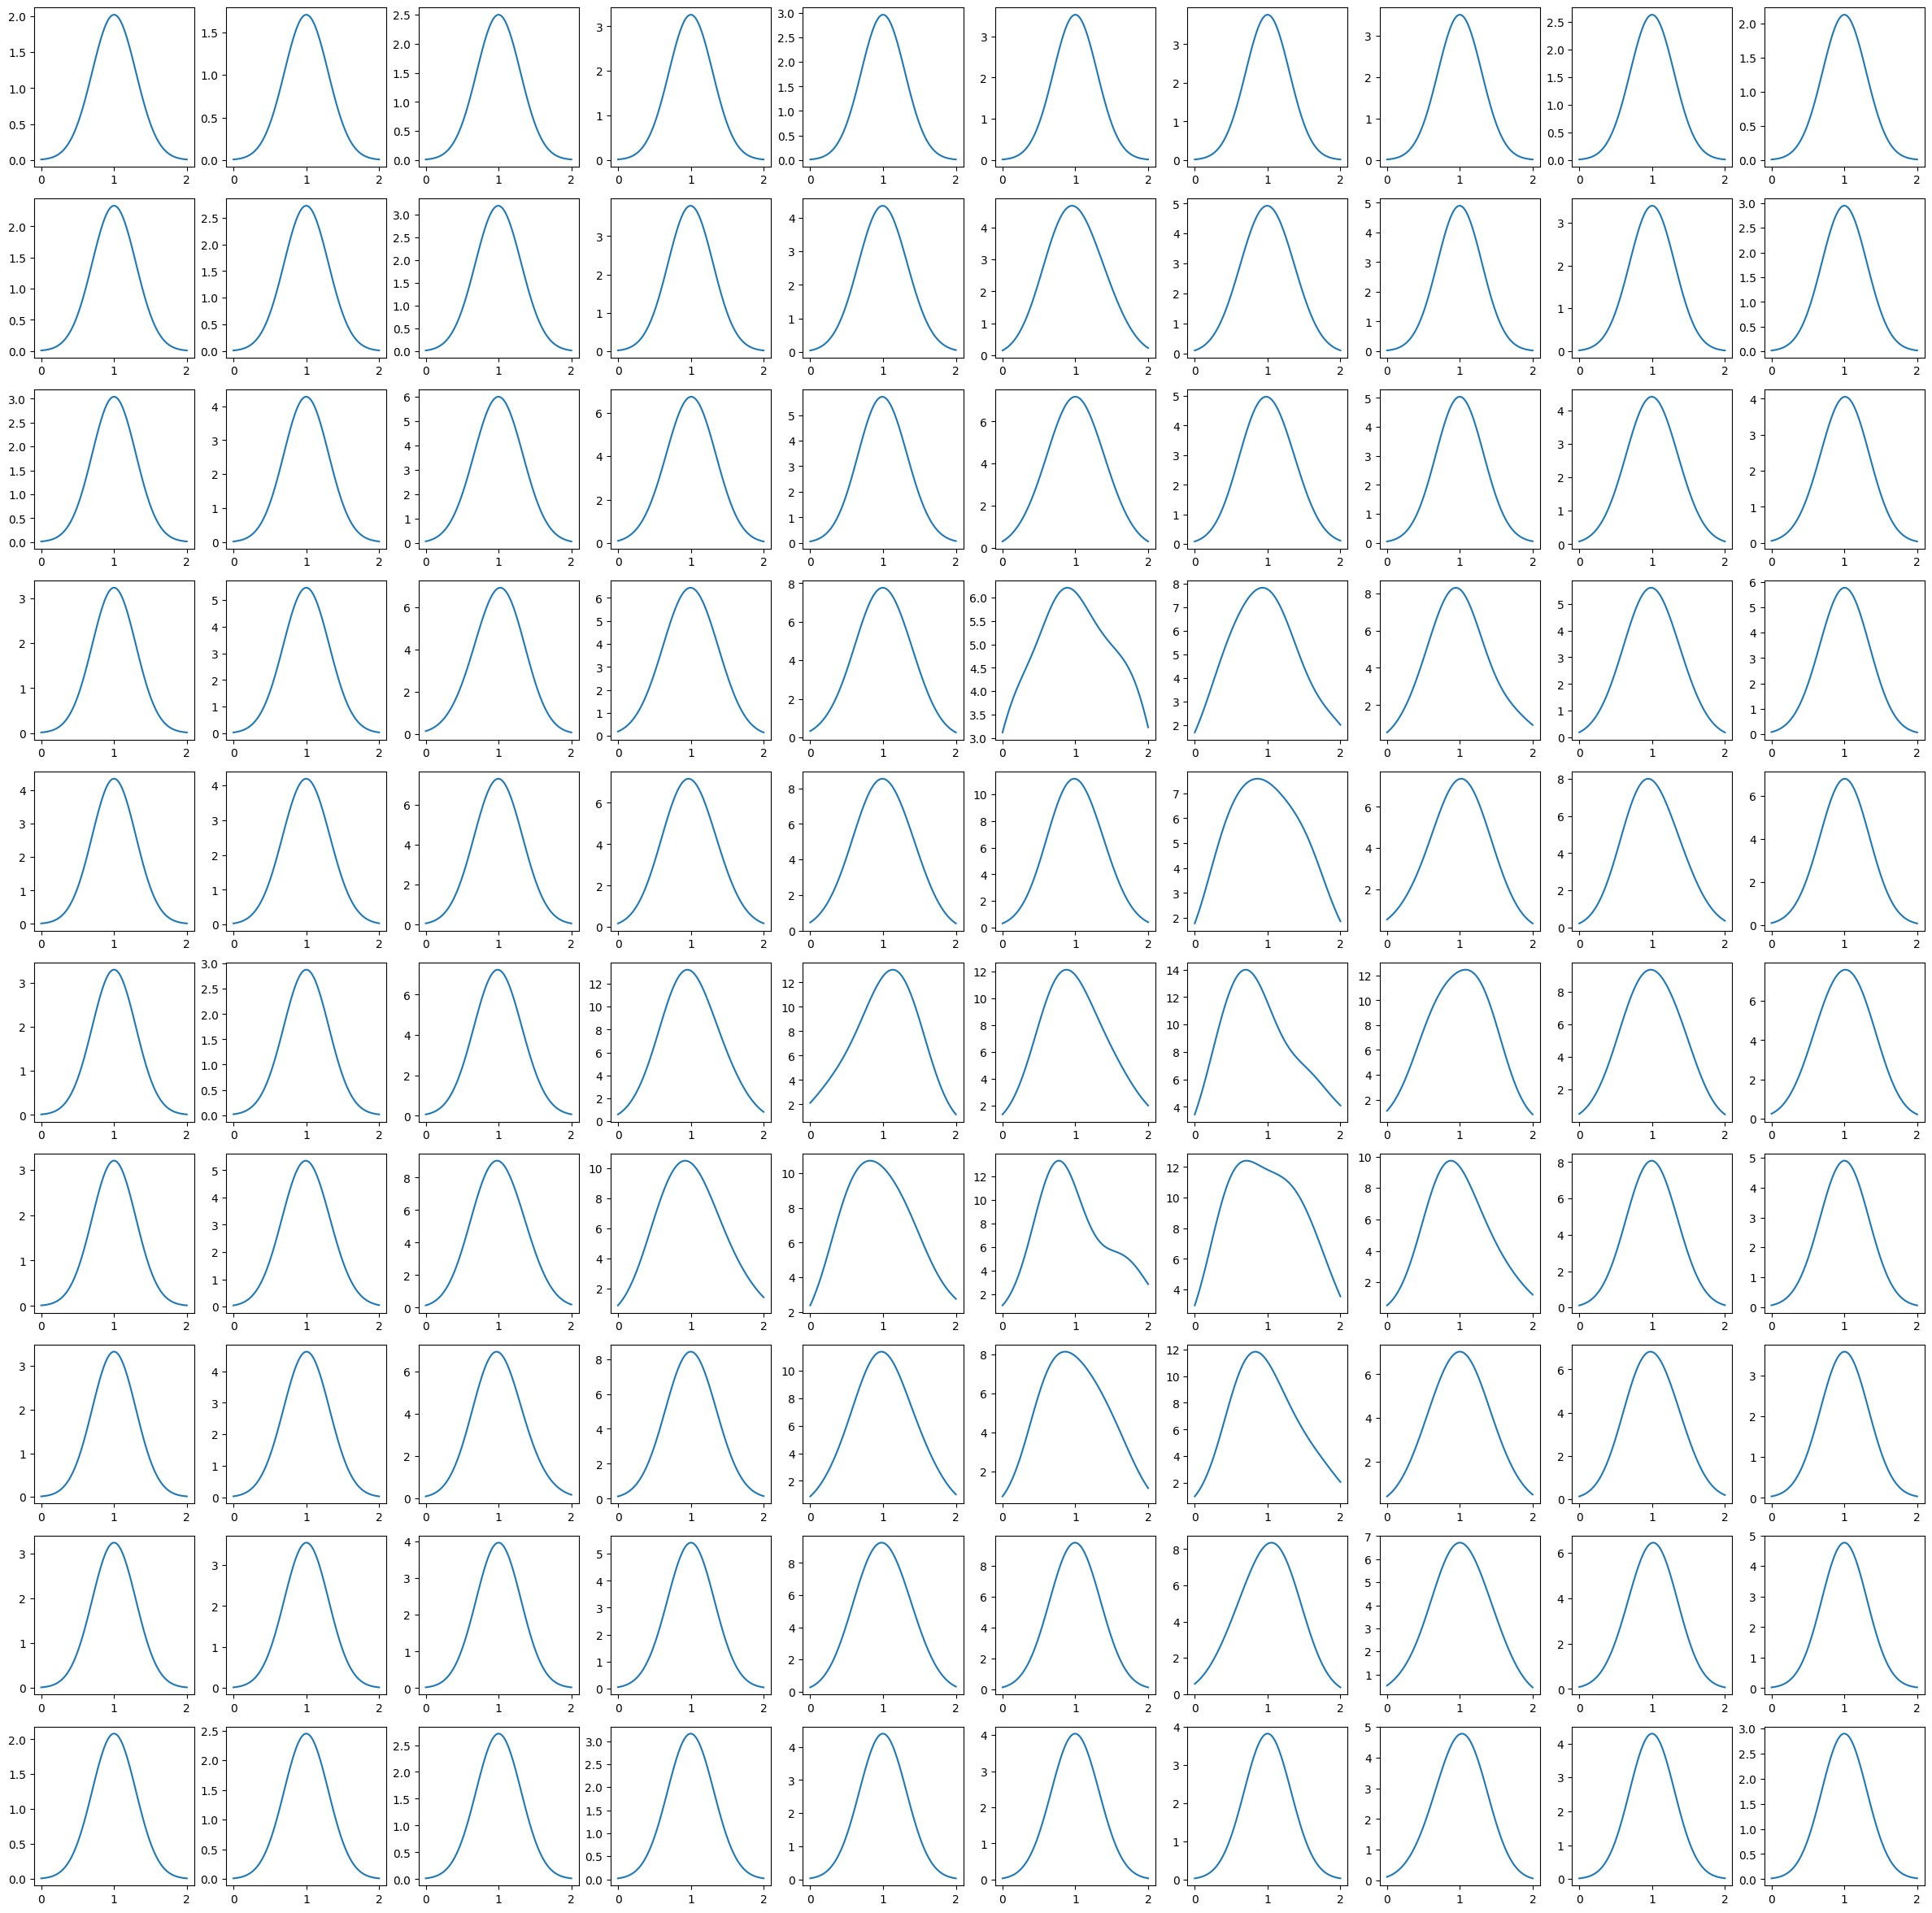

In [26]:
fig, axs = plt.subplots(10, 10, figsize=(30, 30))

# # Taking the mean of windows of N//10 pixels
# repr_z = np.zeros((10, 10, 100))
# for i in range(10):
#     for j in range(10):
#         repr_z[i,j,:] = np.mean(spectrum_hypercube_z[i*N//10:(i+1)*N//10, j*N//10:(j+1)*N//10, :], axis=(0,1))

# Taking one pixel every 10
repr_z = spectrum_hypercube_z[::N//10,::N//10, :]

for i in range(10):
    for j in range(10):
        axs[i,j].plot(f, repr_z[i,j,:])

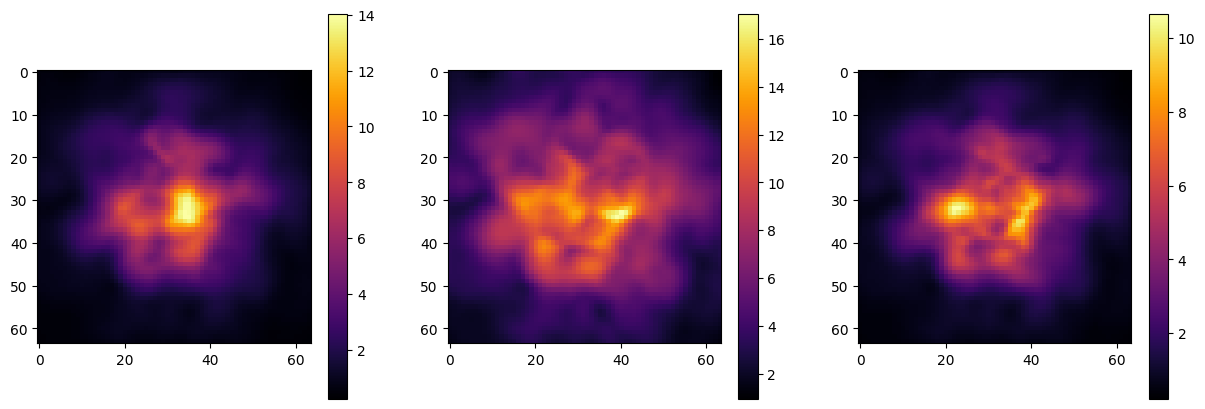

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im = axs[0].imshow(spectrum_hypercube_z[:,:,25], cmap="inferno")
fig.colorbar(im)
im = axs[1].imshow(spectrum_hypercube_z[:,:,50], cmap="inferno")
fig.colorbar(im)
im = axs[2].imshow(spectrum_hypercube_z[:,:,75], cmap="inferno")
fig.colorbar(im)
plt.show()